# Assignment 2

In this assignment the goal is to be able to price a game based on an image. This will be done using a convolutional neural network.
For this assignment three methods are developed with the goal of pricing the games:
1. Building a CNN that does not take into consideration that some screenshots belong to the same game.
1. Building a CNN that takes into consideration that some screenshots belong to the same game by stitching the screenshots of a game together to create one large image. This large image is then fed into the CNN. 
1. Building a CNN that takes into consideration that some screenshots belong to the same game by using multiple screenshots of a game as input of a multi-branch CNN with a concatenated layer.

First, some general pre-processing is discussed. This ensures that the same splits will be used for each method. Then, for each method the pre-processing steps are discussed. Then each model with the necessary evaluation criteria is built. Then, based on the the evaluation metric, the best of the three beforementioned methods is selected. Lastly, some interpretability techniques to get insights on the model is given. 

To start, the necessary packages and data are loaded in. The data with for each game the related price and images are included. Additionally, a path is created to where the images are stored on the local device.

In [1]:
#Load the following packages:
import os
import json
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import tensorflow as tf


# Set the location of where the images are stored. Adjust to the correct location when running the code!
image_location = '/Users/sarahguilliams/Desktop/Advanced Analytics in a Big Data World/Assignment2/images'

#  Load the json datafile
file_path = "dataset.json"

# Open the JSON file and load its contents
with open(file_path, 'r') as file:
    data = json.load(file)

data1 = pd.DataFrame(data) #Make sure that the data has the DataFrame format
data1.head() #print the first 5 rows with data

appid     release                             title  price sentiment  \
0  2805630  2024-02-24                         BotMobile   1173  Positive   
1  2805610  2024-02-24  Just skill shooter 3: 2d edition    199  Positive   
2  2816420  2024-02-24                        Slime Drop    199      None   
3  2815670  2024-02-24               Path to the Creator    299      None   
4  2776190  2024-02-24                  Crowd Control VR   1179      None   

  reviews percentage                                               tags  \
0      10        100  [Action, Action-Adventure, Adventure, Casual, ...   
1      11         90  [2D, Action, Action RPG, Action-Adventure, Adv...   
2    None        NaN  [2D, Arcade, Casual, Clicker, Colorful, Cute, ...   
3    None        NaN  [2D, Action RPG, Adventure, Character Customiz...   
4    None        NaN  [360 Video, Arcade, Cartoony, Casual, Fantasy,...   

                                         screenshots  
0  [2805630_ss_02b69bffacf19807fb6202fb8167fad7e0...  
1  [2805610_ss_21f5dfd4d369f1cefdd9d233f574a4758d...  
2  [2816420_ss_649a6c5bb66b93bf7b0a384d412923618d...  
3  [2815670_ss_06c8a39fd0618390bdedaff037f2463ca4...  
4  [2776190_ss_01d6152f8e559e051312ea5e6232ba1ecb...

In [15]:
import pandas as pd


# Count the total number of games
total_games = len(data1)

# Count the number of games with price below 5000
games_below_2000 = len(data1[data1['price'] < 5000])

# Calculate the proportion
proportion_below_2000 = games_below_2000 / total_games

# Print the result
print(f"Proportion of games with price below 5000: {proportion_below_2000:.2f}")

# If you want to see the count as well
print(f"Total games: {total_games}")
print(f"Games with price below 2000: {games_below_2000}")


Proportion of games with price below 5000: 0.99
Total games: 14687
Games with price below 2000: 14498


A key aspect of this assignment is accounting for the fact that a game can have multiple images. Therefore, when splitting the data into the training, validation, test split, this split should be made based on the games and not the seperate images. For this assignment the decision was made to split our data 60/20/20. 

Note that in order to also create a dataset for validation, a train-test split must be performed two times. In the first split the test set is generated. In the second split, the training set from the initial split is used to generate a training and a validation dataset.

count     14687.000000
mean       1241.069585
std        9214.536905
min           0.000000
25%         199.000000
50%         499.000000
75%         998.000000
max      512850.000000
Name: price, dtype: float64
count    14611.000000
mean       797.721443
std        974.957470
min          0.000000
25%        199.000000
50%        499.000000
75%        975.000000
max       9950.000000
Name: price, dtype: float64
0.00517464424320828


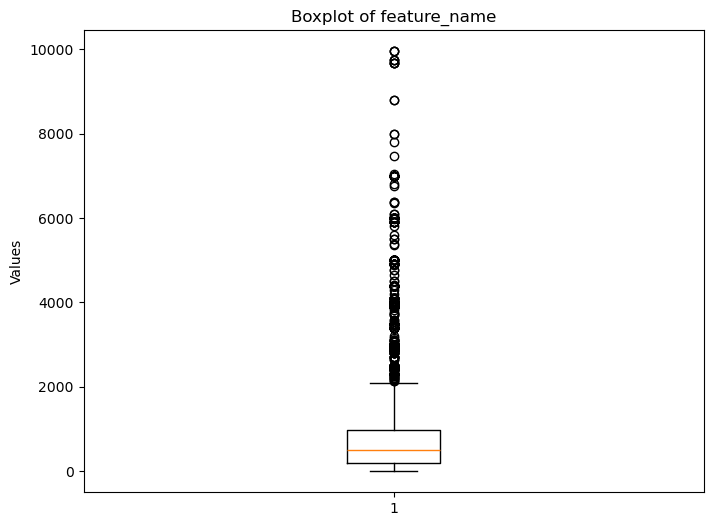

In [2]:
# Select a portion of the games. If we want to train on all of the data, set it equal to 1.
num_selected_games = int(len(data1))
np.random.seed(0) #This is so that we get the same games when training the model.
selected_games = data1.sample(n=num_selected_games)
#print(selected_games) 
print(selected_games['price'].describe())

# Remove the outliers
selected_games_no_outliers = selected_games[selected_games['price'] <= 10000]
print(selected_games_no_outliers['price'].describe())

# Deleted percentage of games
deleted = (len(selected_games['price']) - len(selected_games_no_outliers['price'])) / (len(selected_games['price']))
print(deleted) # 0.5% of the games are removed 

# TO DO: create two boxplots, before and after removing the outliers
plt.figure(figsize=(8, 6))
plt.boxplot(selected_games_no_outliers["price"])
plt.title('Boxplot of {}'.format('feature_name'))
plt.ylabel('Values')
plt.show()


In [3]:
# train test split
from sklearn.model_selection import train_test_split
# Split data into training and validation sets based on games
train1_games, test_games = train_test_split(selected_games_no_outliers, test_size=0.2, random_state=42) 
train_games, val_games = train_test_split(train1_games, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

Additionally, a preventative measure is taken to detect corrupted images. For this assignment a large zip file needed to be downloaded. Therefore, it did occur that some images became corrupted. This section of code is built to detect these corrupted images. The corrupted images were then mannually removed from the images folder.

# To do: change this to code
from PIL import Image
extensions = []
for fldr in os.listdir(image_location):
    if fldr == '.DS_Store':
        continue
    file_path = os.path.join(image_location, fldr)
    print('** Path: {}  **'.format(file_path), end="\r", flush=True)
    im = Image.open(file_path)
    rgb_im = im.convert('RGB')
    if fldr.split('.')[1] not in extensions:
        extensions.append(fldr.split('.')[1])

In the last step of the general pre-processing, some general parameters are defined. This ensures that there is coherence between three models that are proposed in this assignment. 


First, the screenshorts are resized. The original shape of the images have a height of 1080 pixels and a width of 1920 pixels. As discussed later in more detail, this assignment will make use of pre-trained models. These pre-trained models sometimes have constraints on the size of the images that they can process. Therefore, this step already resizes the images to take account of these constraints. 

In [4]:
### Defining some global parameters:

# Resizing the images
reduction = 0.25
width = 224 #1920*reduction
height = 224 #1080*reduction
#height width
image_size = (height, width)

#batch size
batch_size = 32

## Method 1: CNN without accounting for the fact that each game contains multiple images

In this section, the first method of prediciting the price of a game using the image is discussed. In this method the images will be used as input of the CNN the predict the price without accounting for the fact that a game has multiple images. The input of this model is each individual image of the game and the output will be the price.

### Pre-processing

A key aspect of the pre-processing step is normalizing the images and performing some data augmentations (ex. rotations, flips, ...). When performing this pre-processing account must be taken of the fact that there are over 125k images available. This makes it very difficult to manually load in and augment the images. A workaround for this is by using the ImageDataGenerator function in combination with a flow_from_dataframe function (inspired by the following stackoverflow question: https://stackoverflow.com/questions/41749398/using-keras-imagedatagenerator-in-a-regression-model). The ImageDataGenerator progressively loads images into the memory while training the model. 

As the flow_from_dataframe function is used, first, a dataset with in first column the screenshot (the feature) and in the second column the price (the target) is created for respectively the training, validation and test set.  

In [5]:
# Create a list of dictionaries for DataFrame
train_data = []
for index, game in train_games.iterrows():
    for screenshot in game['screenshots']:
        train_data.append({'screenshot': screenshot, 'price': game['price']})

# Create DataFrame
train_label_df = pd.DataFrame(train_data)

# Do the same for the validation set
val_data = []
for index, game in val_games.iterrows():
    for screenshot in game['screenshots']:
        val_data.append({'screenshot': screenshot, 'price': game['price']})

val_label_df = pd.DataFrame(val_data)


# Do the same for the test set
test_data = []
for index, game in test_games.iterrows():
    for screenshot in game['screenshots']:
        test_data.append({'screenshot': screenshot, 'price': game['price']})

test_label_df = pd.DataFrame(test_data)

 Compare the distribution of prices in train_games (distribution of the games) and the prices in train_data (distribution per image) and if there is a large diviance there

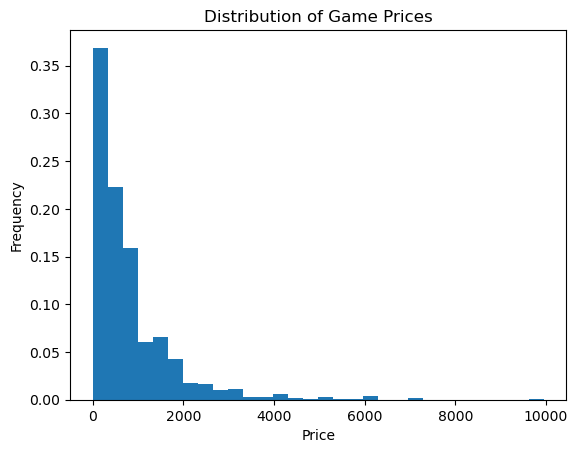

In [6]:
# Multiply y-axis values by 100 to represent percentages
plt.hist(train_games['price'], weights=np.zeros_like(train_games['price']) + 1. / train_games['price'].size, bins=30)

# Add labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Game Prices')

# Show plot
plt.show()

In [11]:
train_label_df.head()

screenshot  price
0  2287100_ss_17e0c6656051dfaacb1885b94a15695677b...    199
1  2287100_ss_2ef9a930a8303315019e015d2d96713da21...    199
2  2287100_ss_348fdf20fdeda0d20ce51bf2e97a7899d88...    199
3  2287100_ss_866f7a39e837f19117fa11d563fd6b66a53...    199
4  2287100_ss_9af9617ed98d9430ab3982b298644bfaa0c...    199

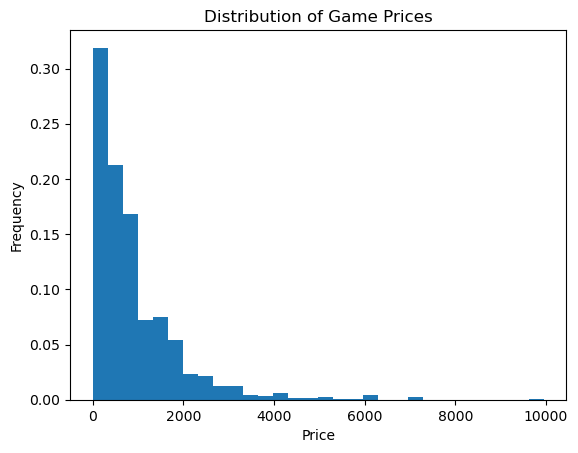

In [12]:
# Multiply y-axis values by 100 to represent percentages
plt.hist(train_label_df['price'], weights=np.zeros_like(train_label_df['price']) + 1. / train_label_df['price'].size, bins=30)

# Add labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Game Prices')

# Show plot
plt.show()

Analysis of the proportion of games below 2000

In [16]:
import pandas as pd

# Count the total number of games
total_games = len(train_label_df)

# Count the number of games with price below 2000
games_below_2000 = len(train_label_df[train_label_df['price'] < 2000])

# Calculate the proportion
proportion_below_2000 = games_below_2000 / total_games

# Print the result
print(f"Proportion of games with price below 2000: {proportion_below_2000:.2f}")

# If you want to see the count as well
print(f"Total games: {total_games}")
print(f"Games with price below 2000: {games_below_2000}")


Proportion of games with price below 2000: 0.92
Total games: 76624
Games with price below 2000: 70521


In [21]:
import pandas as pd
from sklearn.utils import resample

print("Original size", len(train_label_df))

# Separate the majority and minority classes
majority_class = train_label_df[train_label_df['price'] < 2000]
minority_class = train_label_df[train_label_df['price'] >= 2000]

# Print the sizes of both classes
print(f"Minority class size: {len(minority_class)}")
print(f"Majority class size: {len(majority_class)}")

# Undersample the majority class
n_samples_to_draw = int(len(minority_class) * 0.5) 
minority_class_undersampled = resample(minority_class, 
                                       replace=False,  # sample without replacement
                                       n_samples=n_samples_to_draw,  # match minority class size
                                       random_state=42)  # reproducible results

# Combine minority class with undersampled majority class
undersampled_df = pd.concat([majority_class, minority_class_undersampled])

# Shuffle the resulting dataframe
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the undersampled dataframe
print(undersampled_df)
print("Removing some high prices above 2000", len(undersampled_df))

# Check the distribution
print(undersampled_df['price'].value_counts())


Original size 76624
Minority class size: 6103
Majority class size: 70521
                                              screenshot  price
0      2546150_ss_84d64343e9a34188a7899b0e49b25f9ddb1...   1479
1      2323220_ss_c11f0716ed88894cdfe6d1909ddafacb5a5...     90
2      2297880_ss_bccb5400403ec4f00f4552250bd1d568a4b...    975
3      2736210_ss_d08bdc6b0d11952b25c30deebb4474ce1c9...    399
4      2396380_ss_347f3dda7fb8ac4dd0d1eb769f707573bc5...     99
...                                                  ...    ...
73567  2232680_ss_deb0957cd82da8e8f034cc6c20f5b9c719c...    499
73568  2644010_ss_431a0c13340ceba29cfd430e253a6def4eb...   1579
73569  2396300_ss_c2b888acfce05f62130b52f47bfce7edde9...      0
73570  1751350_ss_9097e0a286dbf68379c72394b2054898a08...   1279
73571  1295000_ss_bbe3af41b6555fc568813f76af9a98b4662...    499

[73572 rows x 2 columns]
Removing some high prices above 2000 73572
price
0       10310
499      7942
975      5210
299      4633
399      4075
        ...  


Next, the ImageDataGenerator is defined. 


In [22]:
# Transormations for the training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, 
                                                                        rotation_range=45, horizontal_flip=True, vertical_flip=True)


train_generator = train_datagen.flow_from_dataframe(dataframe=undersampled_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size, shuffle=True,
                                              batch_size=batch_size)

# For the validation data
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 
val_generator = val_datagen.flow_from_dataframe(dataframe=val_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size, shuffle=True,
                                              batch_size=batch_size)

# for the test set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 
# here we don't perform any transormations

test_generator = test_datagen.flow_from_dataframe(dataframe=test_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size,
                                              batch_size=batch_size)


Found 73571 validated image filenames.


/Users/sarahguilliams/anaconda3/lib/python3.11/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(


Found 25876 validated image filenames.


/Users/sarahguilliams/anaconda3/lib/python3.11/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(


Found 25576 validated image filenames.


Using transfer learning (using a pre-trained model)
https://keras.io/guides/transfer_learning/
Remove the top last layers so these can be trained on our data.
https://www.tensorflow.org/guide/keras/transfer_learning
https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets

## Architecture of the model

batch normalization : https://wandb.ai/authors/ayusht/reports/Batch-Normalization-in-Keras-An-Example--VmlldzoxNzI5NjQ need to use small batch size

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential


inputs= layers.Input(shape=(height, width, 3))


base_model = ResNet50(
    include_top=False, #Do not use the imagenet at the top
    weights="imagenet",
    pooling=None
)

# Freeze the base model
base_model.trainable = False

x = base_model(inputs, training=False)

# Add a layer on top
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3, name="top_dropout")(x)
x = layers.BatchNormalization()(x)
# inspired by https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/ 
outputs = layers.Dense(1, activation = 'relu', name="prediction")(x) # Used ReLu activation function because prices are always positive

model = keras.Model(inputs, outputs)



## Prevention of overfitting

Cannot use MAPE because there are prices equal to zero => will not work
How we are preventing overfitting:
- keeping track of a validation set and early stopping if the validation set has reached its minimum level (so the delta does not increase anymore)
- Dropout
- Batch normalization

Loss function: using rmse 
This depends on your loss function. In many circumstances it makes sense to give more weight to points further away from the mean--that is, being off by 10 is more than twice as bad as being off by 5. In such cases RMSE is a more appropriate measure of error. https://stats.stackexchange.com/questions/48267/mean-absolute-error-or-root-mean-squared-error 



As mentioned above, Cyclical Learning Rates enables our learning rate to oscillate back and forth between a lower and upper bound.

So, why bother going through all the trouble?

Why not just monotonically decrease our learning rate, just as we’ve always done?

The first reason is that our network may become stuck in either saddle points or local minima, and the low learning rate may not be sufficient to break out of the area and descend into areas of the loss landscape with lower loss.

Secondly, our model and optimizer may be very sensitive to our initial learning rate choice. If we make a poor initial choice in learning rate, our model may be stuck from the very start.

Instead, we can use Cyclical Learning Rates to oscillate our learning rate between upper and lower bounds, enabling us to:

Have more freedom in our initial learning rate choices.
Break out of saddle points and local minima.
In practice, using CLRs leads to far fewer learning rate tuning experiments along with near identical accuracy to exhaustive hyperparameter tuning.

In [25]:
# Adding cyclical learning rate
from keras.callbacks import *
from clr_callback import CyclicLR
from keras.optimizers import Adam, SGD
from keras.losses import Huber

#set the CLR options
clr_step_size = int(4 * (len(train_generator)/batch_size)) #see paper https://arxiv.org/pdf/1506.01186
base_lr = 1e-7
max_lr = 1e-2
mode='triangular'


# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
clr_triangular = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=clr_step_size, mode=mode)
opt = Adam(0.001)

# Adding an early stopping mechanism
EarlyStoppinng = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=1,
    start_from_epoch=3,
)

model.compile(optimizer=opt, loss=Huber(delta=1.0), metrics=[keras.metrics.MeanAbsoluteError()])
print("Model is compiled")
# Loss function: the parameter that is used to optimize the model, i.e. the loss function is minimized by the model
# Metric: what is used to evaluate the model performance (this can be used to compare different models)



Model is compiled


In [26]:
# Fitting the model
# fit the model
history = model.fit(
    train_generator,
    callbacks=[ EarlyStoppinng, clr_triangular],
    steps_per_epoch=train_generator.n//batch_size,
    epochs=6,
    validation_data=val_generator,
    validation_steps = val_generator.n//batch_size
)

Epoch 1/6


2024-05-17 00:47:16.465395: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2299/2299 [==============================] - 4243s 2s/step - loss: 561.1987 - mean_absolute_error: 561.6966 - val_loss: 670.7320 - val_mean_absolute_error: 671.2306
Epoch 2/6
2299/2299 [==============================] - 4339s 2s/step - loss: 546.9512 - mean_absolute_error: 547.4511 - val_loss: 663.8994 - val_mean_absolute_error: 664.3987
Epoch 3/6
2299/2299 [==============================] - 4309s 2s/step - loss: 546.9727 - mean_absolute_error: 547.4722 - val_loss: 661.9821 - val_mean_absolute_error: 662.4817
Epoch 4/6
2299/2299 [==============================] - 4308s 2s/step - loss: 546.4050 - mean_absolute_error: 546.9047 - val_loss: 662.5663 - val_mean_absolute_error: 663.0651
Epoch 5/6
2299/2299 [==============================] - 4304s 2s/step - loss: 546.1262 - mean_absolute_error: 546.6258 - val_loss: 662.1184 - val_mean_absolute_error: 662.6177
Epoch 6/6
2299/2299 [==============================] - 4305s 2s/step - loss: 546.3707 - mean_absolute_error: 546.8705 - val_loss: 663.2

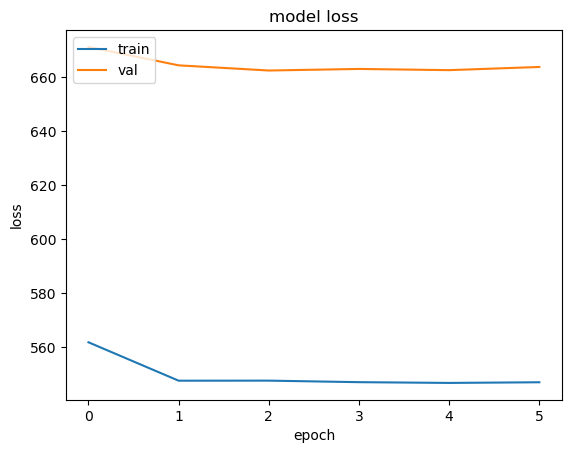

In [27]:
# Plotting the error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

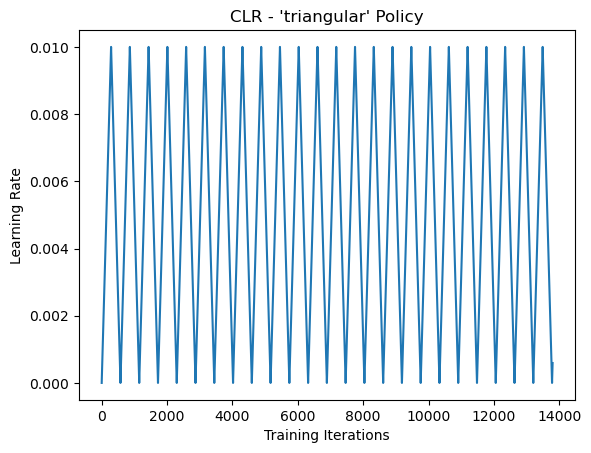

In [28]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])


We can run two additional epochs where we train the last two layers of the model using a lower learning rate

In [ ]:
# Fine-Tuning the model
# see https://www.tensorflow.org/tutorials/images/transfer_learning


In [29]:
# Evaluate model
loss, mean_absolute_error = model.evaluate(test_generator, steps = test_generator.n//batch_size)


799/799 [==============================] - 1113s 1s/step - loss: 653.2034 - mean_absolute_error: 653.7025


In [39]:
print("Test MAE:", mean_absolute_error)

Test MAE: 651.044677734375


In [46]:
# Assuming you have a model already trained and stored in a variable called 'model'
# You can save it to HDF5 format using the save method
tf.keras.models.save_model(model, "my_model_no_outliers_1.h5")
#loaded_model = keras.models.load_model("my_model.h5")

In [30]:
test_label_df.head(20)

screenshot  price
0   2005580_ss_40fe31e92de1ecf7d8f0da0199b6e7ad07c...    975
1   2005580_ss_46de62b714bba8ca4d75d8824d21a0b2453...    975
2   2005580_ss_809551512678ead8e48572fcf33ecb1123b...    975
3   2005580_ss_ac39d449bd781962e7ecca29da85131b0e9...    975
4   2005580_ss_d23061be43ae16d3c0898211afab9fc2fa1...    975
5   2005580_ss_e079c17ba52078862213ffedd2c861aebce...    975
6   2368070_ss_01753a37771ec2b139b1d3362a57e8ab662...    689
7   2368070_ss_135d6e05a4fd4ac2dc2af1163c8d67f61e6...    689
8   2368070_ss_46f9cc5ca49265981f9c4a0b9d75e280fd6...    689
9   2368070_ss_b1264d59affce3929e2e56b5b1e2d17de20...    689
10  2368070_ss_d317c08613b1885bf768beb6f5010741018...    689
11  2368070_ss_d6a8a5936f71d4a5195c151253cbeee8f23...    689
12  1993730_ss_438b4f3f150a71f4aff73de8a8499755023...   1179
13  1993730_ss_4452115b008a644beee774b29457616e0fc...   1179
14  1993730_ss_4e1bd8f59f4e1049f479cd532656b19e261...   1179
15  1993730_ss_538fa2022a1ddba752f79e2f371344e5265...   1179
16  1993730_ss_76594dbfc46ab93caacce4d51f06f09ed18...   1179
17  1993730_ss_85a19d25c005aaeb43b8bc4dd19bfa93d3b...   1179
18  1993730_ss_bb843f62c0f019b61354fcee931d09db6c0...   1179
19  1993730_ss_ecbfd3baec9a1b244d18a63080907d0de9d...   1179

Give the predicted price for a game


1928030_ss_7a0de79fea6fbeef10585572e15d41b4414d3aaf.1920x1080.jpg


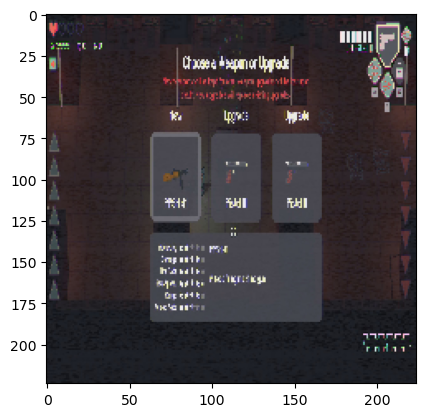

AttributeError: module 'keras' has no attribute 'ops'

In [22]:
# Define the image location
number = 450
print(test_label_df.loc[number, "screenshot"])
filename = test_label_df.loc[number, "screenshot"]
#'620620_ss_01fe128c1e30f3cc9cee30fa4bbdb7f60e9abe67.1920x1080.jpg'

# Construct the full path to the image
image_path = os.path.join(image_location, filename)

# Load and display the image
img = keras.utils.load_img(image_path, target_size=(height, width))
plt.imshow(img)
plt.show()

img_array = keras.utils.img_to_array(img)
img_array = img_array/255.0
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)
print(test_label_df.loc[number, "price"])




In [12]:
base_model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

_________________________________________________________________________________________________________________________

In [6]:
#loaded_model = keras.models.load_model("my_model.h5")

In [32]:
pred = []

for i in range(len(test_label_df)):
    filename = test_label_df.iloc[i]["screenshot"]
    image_path = os.path.join(image_location, filename)
    img = keras.utils.load_img(image_path, target_size=(224, 224))


    img_array = keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image data
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    price_difference = predictions[0][0] - test_label_df.iloc[i]["price"]
    pred.append({'price': predictions[0][0], 'difference': price_difference})

    print('prediction ', i , predictions[0][0] , 'Difference:', price_difference)

predictions_test = pd.DataFrame(pred)
predictions_test.head();

1/1 [==============================] - 0s 99ms/step
prediction  0 441.9624 Difference: -533.03759765625
1/1 [==============================] - 0s 73ms/step
prediction  1 529.9508 Difference: -445.0491943359375
1/1 [==============================] - 0s 71ms/step
prediction  2 462.45477 Difference: -512.5452270507812
1/1 [==============================] - 0s 63ms/step
prediction  3 547.9765 Difference: -427.02349853515625
1/1 [==============================] - 0s 68ms/step
prediction  4 463.2336 Difference: -511.7663879394531
1/1 [==============================] - 0s 63ms/step
prediction  5 397.0808 Difference: -577.919189453125
1/1 [==============================] - 0s 73ms/step
prediction  6 510.07587 Difference: -178.92413330078125
1/1 [==============================] - 0s 74ms/step
prediction  7 515.3626 Difference: -173.63739013671875
1/1 [==============================] - 0s 68ms/step
prediction  8 575.45654 Difference: -113.54345703125
1/1 [==============================] - 0s 66m

In [33]:
print(min(predictions_test['price']))
print(sum(predictions_test['price'])/ len(predictions_test['price']))
print(max(predictions_test['price']))

0.0
530.9025733215589
15125.97265625


Text(0.5, 0, 'Actual')

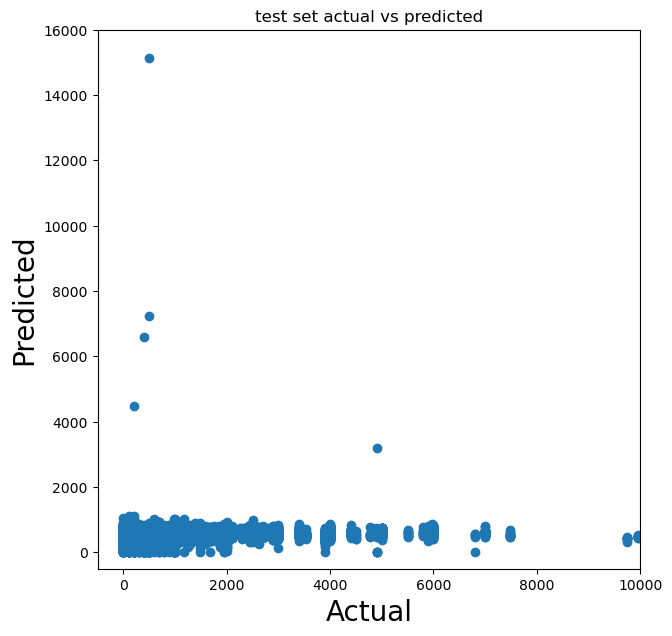

In [34]:
plt.figure(figsize = (7,7))
plt.axis([-500, 10000, -500, 16000])
plt.scatter(test_label_df['price'], predictions_test['price'])
#plt.plot([min(test_label_df['price']), max(test_label_df['price'])], [min(test_label_df['price']), max(test_label_df['price'])], color="r", linestyle="-", linewidth=2)
plt.title("test set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)

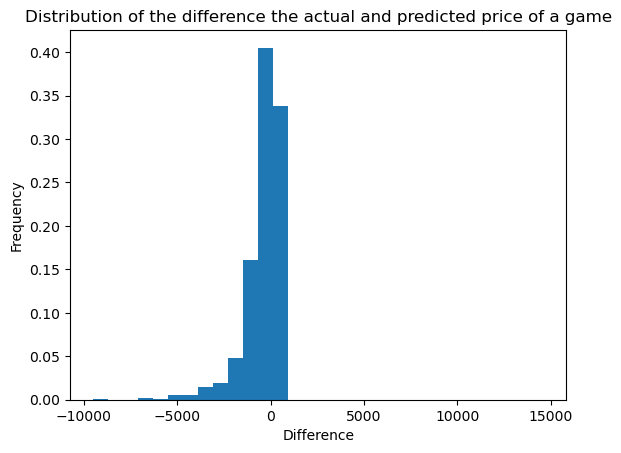

In [36]:
# Plot histogram of the differences in price
# Multiply y-axis values by 100 to represent percentages
plt.hist(predictions_test['difference'], weights=np.zeros_like(predictions_test['difference']) + 1. / predictions_test['difference'].size, bins=30)
# test_games
#train_games
# Add labels and title
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Distribution of the difference the actual and predicted price of a game')

# Show plot
plt.show()

In [45]:
from sklearn.metrics import mean_absolute_error 
y_true = test_label_df['price']
y_pred = predictions_test['price']


# Calculate the mean absolute error, should correspond to the test error
mae = mean_absolute_error(y_true, y_pred)


print("Mean Absolute Error:", mae)


Mean Absolute Error: 651.0081900734807


In [43]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_label_df['price'], predictions_test['price']))
# print('Mean Absolute Error (without outliers):', metrics.mean_absolute_error(y_test_wo_outliers, y_pred_wo_outliers))
print('Mean Squared Error:', metrics.mean_squared_error(test_label_df['price'], predictions_test['price']))
# print('Mean Squared Error (without outliers):', metrics.mean_squared_error(y_test_wo_outliers, y_pred_wo_outliers))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_label_df['price'], predictions_test['price'])))
# print('Root Mean Squared Error (without outliers):', np.sqrt(metrics.mean_squared_error(y_test_wo_outliers, y_pred_wo_outliers)))
print('R2 score:', metrics.r2_score(test_label_df['price'], predictions_test['price']))

Mean Absolute Error: 651.0081900734807
Mean Squared Error: 1091485.192122023
Root Mean Squared Error: 1044.7416867924928
R2 score: -0.048038992767728494


### Visualisation/interpretability technique


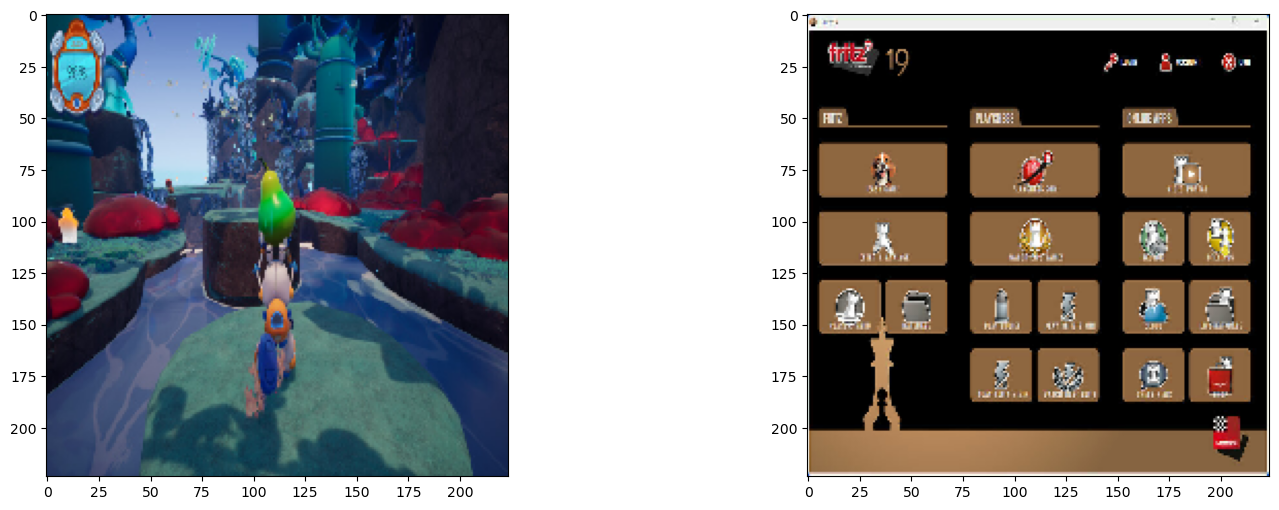

In [72]:
from matplotlib import pyplot as plt

#matplotlib inline
# Define the image location
number1 = 500 #780 is the tanks
number2 = 507
#print(test_label_df.loc[number, "screenshot"])
filename1 = test_label_df.loc[number1, "screenshot"]
price1 = test_label_df.loc[number1, "price"]
filename2 = test_label_df.loc[number2, "screenshot"]
price2 = test_label_df.loc[number2, "price"]

# Construct the full path to the image
image_path1 = os.path.join(image_location, filename1)
image_path2 = os.path.join(image_location, filename2)

# Load and display the image
plt.rcParams['figure.figsize'] = (18, 6)

img1 = keras.utils.load_img(image_path1, target_size=(height, width))
img2 = keras.utils.load_img(image_path2, target_size=(height, width))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

In [73]:
# Github
# https://github.com/keisen/tf-keras-vis/tree/master


# Preprocess images, so that they are normalized
img_array = keras.utils.img_to_array(img1)
img_array = img_array / 255.0  # Normalize the image data
#print(img_array.shape)
#img_array = tensorflow.expand_dims(img_array, 0)  # Create batch axis
#print(img_array.shape)

# Model modifier: Such that the last layer has a linear activation function.
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
replace2linear = ReplaceToLinear()

#Score function: should return the target score
def score(output):
    return output[0][0]

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import num_of_gpus

# Create Gradcam object
saliency = Saliency(loaded_model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
saliency_map = saliency(score, img_array)

In [55]:
saliency_map.shape

(1, 224, 224)

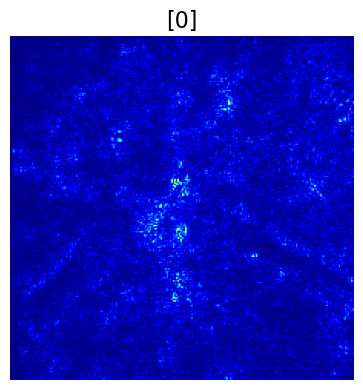

In [74]:

image_title = [price1]
# Plot
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

ax.set_title(image_title, fontsize=16)
ax.imshow(saliency_map[0], cmap='jet')
ax.axis('off')

plt.tight_layout()
plt.show()
    

In [49]:
img_array.shape

(224, 224, 3)

In [37]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                             

In [38]:
from tensorflow.keras.applications.vgg16 import VGG16

test = VGG16(weights='imagenet', include_top=True)
test.summary()

553467096/553467096 [==============================] - 49s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

# TO DO
print 4 images:
    - is expensive, looks cheap
    -looks cheap, is expensive, ...